# Churn Analysis: Timing of Targeting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.externals import joblib

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

# Create Dataset

In [2]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [3]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[(df_cus_orig.first_order_created_datetime >= "2017-01-01")
                          & (df_cus_orig.last_order_created_datetime <= "2018-09-30")].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

33304 / 68891


In [4]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')

In [5]:
df_ord.groupby('city').order_id.nunique()

city
Berlin    15837
London    49233
Paris     36495
Name: order_id, dtype: int64

In [6]:
df_items = pd.read_csv('../data/input/items.csv')

In [7]:
# products one-hot-encoded
df_prods = df_items.pivot_table(values='quantity', index='order_id', columns='product_group', fill_value=0)
df_prods.columns = ['prod_' + c for c in df_prods.columns]
df_prods = df_prods.reset_index()

# overall quantity and basket
df_prods['quantity'] = df_items.groupby('order_id')['quantity'].transform('sum')
df_prods['basket'] = df_items.groupby('order_id')['product_group'].transform(lambda x: ','.join(set(sorted(x))))

df_ord = df_ord.merge(df_prods, on=['order_id'], how='left')

In [8]:
df_ord['days_since_last_seen'] = (datetime(2018,9,30) - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days
df_ord.order_created_datetime = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_day'] = (df_ord.order_created_datetime - datetime(2017, 1, 1)).dt.days
df_ord['order_weekday'] = (df_ord.order_created_datetime).dt.weekday
df_ord['order_month'] = (df_ord.order_created_datetime).dt.month

In [9]:
df_ord = df_ord.drop_duplicates()

In [10]:
last_day = (datetime(2018,9,30) - datetime(2017,1,1)).days
last_day

637

### Completed Dataset

In [11]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['completed_orders'] = df_comp.groupby(['customer_db_id']).transform('count')
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date.dt.date - df_comp.order_created_datetime.dt.date).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime.dt.date - df_comp.last_order_date.dt.date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [12]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['order_day'] = (df_comp.order_created_datetime - datetime(2017, 1, 1)).dt.days

# Customer Lifetime
Created dataframe for customer lifetime

In [13]:
df_life = df_comp.copy()
df_life = df_life.sort_values(['customer_id', 'order_day'])

df_life['first_order'] = df_life.order_comp_num == 0
df_life['last_order'] = df_life.order_comp_num == (df_life.completed_orders - 1)
df_life['returned'] = ~df_life.last_order

df_life['frequency'] = df_life.groupby('customer_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())
df_life['order_day_expected'] = df_life.order_day + df_life.frequency
df_life.order_day_expected = df_life.groupby('customer_id').order_day_expected.shift().fillna(df_life.order_day)
df_life['order_expected_diff'] = df_life.order_day - df_life.order_day_expected

df_life['churn_factor'] = df_life.days_until_next_comp / df_life.frequency
df_life.loc[df_life.last_order, 'churn_factor'] = df_life.days_since_last_seen / df_life.frequency

df_life['order_day_expected_45'] = df_life.order_day + 45 + 8
df_life.order_day_expected_45 = df_life.groupby('customer_id').order_day_expected_45.shift().fillna(df_life.order_day)
df_life['order_expected_45_diff'] = df_life.order_day - df_life.order_day_expected_45

df_life['churned_after'] = df_life.days_until_next_comp > (45 + 8)
df_life.loc[df_life.last_order, 'churned_after'] = df_life.days_since_last_seen > (45 + 8)
df_life['churned_before'] = df_life.groupby('customer_id').churned_after.shift().fillna(False)
df_life.loc[df_life.churned_after, 'entered_inactive'] = df_life.order_day + 45 + 8

df_life['revenue_voucher'] = df_life.revenue + df_life.voucher_value
df_life.loc[~(df_life.voucher_value > 0), 'voucher_channel'] = 'no_voucher'
df_life['voucher_ratio'] = (df_life.voucher_value / df_life.revenue_voucher).round(1)

df_life['returned_CRM'] = df_life.final_click_channel.str.contains('crm')
df_life['returned_CRM'] = df_life.groupby('customer_id').returned_CRM.shift(-1).fillna(False)
df_life['returned_voucher'] = df_life.groupby('customer_id').voucher_value.shift(-1).fillna(0)
df_life['returned_voucher'] = (df_life.returned_voucher > 0)
df_life['over_frequency'] = df_life.churn_factor >= 1
df_life['freq_median'] = df_life.groupby('order_day')['frequency'].transform('median')

In [14]:
df_life.voucher_channel = df_life.voucher_channel.fillna('unknown')

In [15]:
df_life.to_csv('../data/df_life.csv', index=False)

In [16]:
def plot_customer_lifetime(sample_customer):
    df_life_sample = df_life.loc[df_life.customer_id == sample_customer]
    
    fig, ax = plt.subplots(figsize=(10,5))
    # plot vouchers
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.voucher_value > 0], 
                    x='order_day', y='voucher_value', marker='x', color='black', label='voucher_value')
    
    # plot journey and expected journy
    sns.lineplot(data=df_life_sample, x='order_day', y='revenue_voucher', 
                 marker='o', label='order revenue', color='green')
    sns.lineplot(data=df_life_sample, x='order_day_expected', y='revenue_voucher', 
                 marker='o', label='expected_order', color='gray', alpha=0.3)
    
    # plot final click channel
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.final_click_channel.str.contains('crm')],
                   x='order_day', y='revenue_voucher', color='red', label='crm_click', zorder=10)
    
    # plot entering inactive segment
    sns.rugplot(df_life_sample.entered_inactive, color='black', height=1, linestyle='--', label='inactive')
    

    plt.xticks(rotation=70)
    plt.ylim(0)
    plt.title(sample_customer)
    plt.legend()
    plt.show()

In [17]:
samples = df_ord.loc[(df_ord.days_until_next_order > 50) & (df_ord.completed_orders > 3) & (df_ord.order_num == 2)]['customer_id'].sample(3)
samples

40259    CUS-W-AS-94846208
73320    CUS-W-CH-15579034
56696    CUS-W-SB-99218812
Name: customer_id, dtype: object

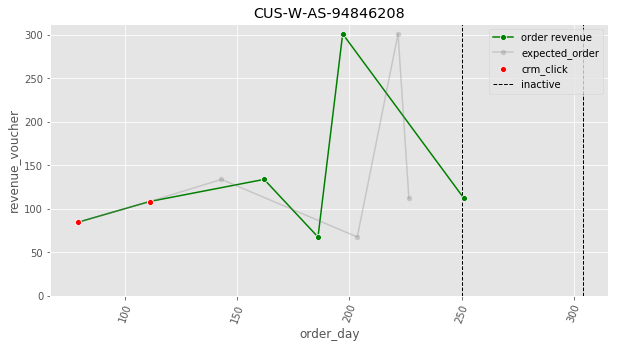

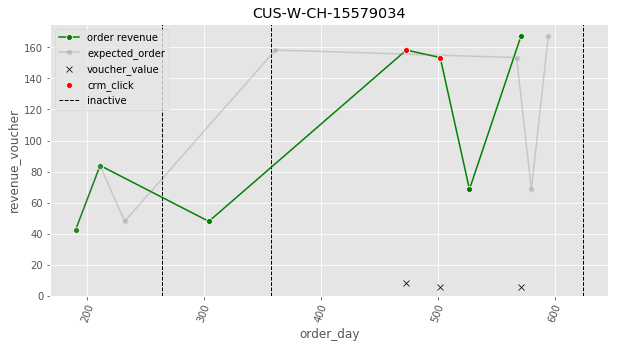

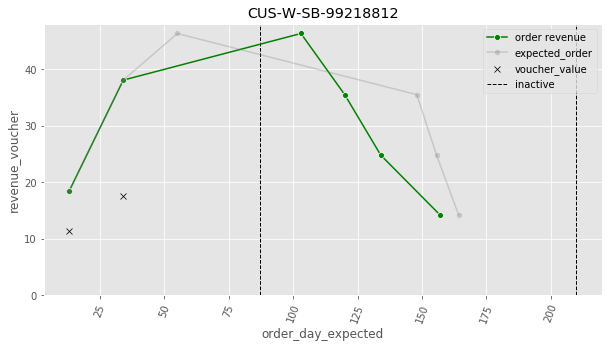

In [18]:
for s in samples:
    plot_customer_lifetime(s)

# Current Impact of Targeting
- based on customers with more than 1 order to use IOF

## Group customers based on frequency
Group customers based on their IOF and compare the impact of targeting for each group.
- good timing: if frequency 53 (45+8) days +/- 7 days
- soon: if frequency > 53+7
- late: if frequency < 53-7

In [19]:
a = df_life.loc[(df_life.order_comp_num > 0) & (df_life.churned_after)]
a['frequency_week'] = a.frequency // 7
a['target_timing'] = ['soon' if x >= 53+10 else 'late' if x <= 53-10 else 'correct' for x in a.frequency]
a['days_until_next_after_target'] = a['days_until_next_comp'] - 53

In [20]:
stats = a.groupby(['frequency_week', 'returned'])['order_id'].nunique().reset_index()
stats['freq_week_total'] = stats.groupby(['frequency_week'])['order_id'].transform('sum')
stats['returned_perc'] = stats.order_id / stats.freq_week_total

(0, 30)

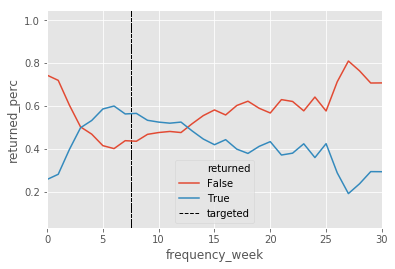

In [21]:
sns.lineplot(data=stats, x='frequency_week', y='returned_perc', hue='returned')
sns.rugplot(np.ones(len(stats)) * 7.5, height=1, color='black', linestyle='--', label='targeted')
plt.legend()
plt.xlim(0,30)

In [22]:
stats = a.loc[a.churned_after]\
            .groupby(['target_timing', 'returned'])['order_id'].nunique().reset_index()
stats['target_total'] = stats.groupby('target_timing')['order_id'].transform('sum')
stats['order_perc'] = stats.order_id / stats.target_total

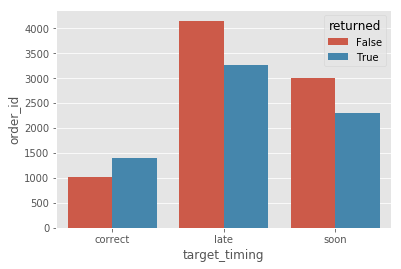

In [23]:
sns.categorical.barplot(data=stats, x='target_timing', y='order_id', hue='returned')

In [24]:
stats

,target_timing,returned,order_id,target_total,order_perc
0,correct,False,1012,2414,0.419221
1,correct,True,1402,2414,0.580779
2,late,False,4152,7412,0.560173
3,late,True,3260,7412,0.439827
4,soon,False,2999,5310,0.564783
5,soon,True,2311,5310,0.435217


In [25]:
a.loc[a.churned_after & a.returned].groupby(['target_timing', 'returned_CRM'])['order_id'].nunique() / \
a.loc[a.churned_after & a.returned].groupby('target_timing')['order_id'].nunique()

target_timing  returned_CRM
correct        False           0.706134
               True            0.293866
late           False           0.758896
               True            0.241104
soon           False           0.610991
               True            0.389009
Name: order_id, dtype: float64

In [26]:
# what is the time until customers come back with CRM campaign after the targeting starts
stats = a.loc[a.returned_CRM].groupby('target_timing')['days_until_next_after_target'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
target_timing,,,,,,,,
correct,412.0,55.228155,62.241867,1.0,15.00,33.0,71.0,438.0
late,786.0,64.061069,76.358833,1.0,15.25,38.0,82.0,542.0
soon,899.0,63.642937,60.308361,1.0,20.00,46.0,89.0,439.0


In [27]:
stats = a.loc[a.returned_CRM]['days_until_next_after_target'].describe()
stats

count    2097.000000
mean       62.146400
std        67.181678
min         1.000000
25%        17.000000
50%        41.000000
75%        82.000000
max       542.000000
Name: days_until_next_after_target, dtype: float64

(0, 175)

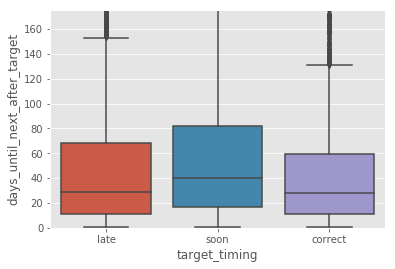

In [28]:
sns.categorical.boxplot(data=a, x='target_timing', y='days_until_next_after_target')
plt.ylim(0,175)

# Predictions
Evaluate predictions based on threshold value, IOF and clustering based on basket.

In [29]:
df_known = df_life.loc[df_life.returned & ~(df_life.corporate) & ~(df_life.returned_voucher) &
                       (df_life.days_until_next_comp < 100)]
df_known.shape

(35453, 121)

In [30]:
df_life.loc[(df_life.order_comp_num == 0) & (df_life.churned_after) & (df_life.days_until_next_comp > 53 + 40)].shape

(2818, 121)

In [31]:
df_life.loc[(df_life.order_comp_num == 0) & (df_life.churned_after) & ~df_life.returned].shape

(14615, 121)

In [32]:
df_life.loc[(df_life.order_comp_num == 0) & df_life.churned_after & df_life.returned & (df_life.days_until_next_comp < 53 + 40)].returned_CRM.value_counts()

False    1276
True      491
Name: returned_CRM, dtype: int64

In [33]:
train_orders, test_orders = train_test_split(df_known.index, test_size=0.1, random_state=42)
test_orders, val_orders = train_test_split(test_orders, test_size=0.5, random_state=42)
len(train_orders), len(test_orders), len(val_orders)

(31907, 1773, 1773)

In [34]:
df_train = df_known.loc[train_orders]
df_test = df_known.loc[test_orders]
df_val = df_known.loc[val_orders]

# Clustering

In [35]:
prod_cols = [c for c in df_known.columns if 'prod_' in c and c not in ['prod_Accessories', 'prod_Others', 'prod_Skiwear']]
prod_cols

['prod_Blazer',
 'prod_Blouse',
 'prod_Coats',
 'prod_Dress',
 'prod_DressSpecial',
 'prod_Household',
 'prod_Knitwear',
 'prod_Shirt',
 'prod_Shorts',
 'prod_Skirt',
 'prod_Suit',
 'prod_Top',
 'prod_Trousers',
 'prod_Tshirt',
 'prod_Underwear',
 'prod_WashFold']

In [36]:
df_train[prod_cols] = df_train[prod_cols].fillna(0).clip(0,1)
df_val[prod_cols] = df_val[prod_cols].fillna(0).clip(0, 1)
df_test[prod_cols] = df_test[prod_cols].fillna(0).clip(0,1)

In [37]:
X_train = df_train[prod_cols]
X_test = df_test[prod_cols]

In [38]:
inertias = []
sils = []
train_error = []
for k in range(2,25):
    kmeans = KMeans(k, random_state=42)
    kmeans.fit(X_train)
    
    i = kmeans.inertia_
    inertias.append(i)
    
#     s = metrics.silhouette_score(X_train, kmeans.labels_, random_state=42)
#     sils.append(s)
    s = 0
    
    df_train_k = df_train.copy()
    df_train_k['cluster'] = kmeans.labels_
    cluster_meds = df_train_k.groupby('cluster')['days_until_next_comp'].median()
    
    df_val_k = df_val.copy()
    df_val_k['cluster'] = metrics.pairwise_distances(df_val_k[prod_cols], kmeans.cluster_centers_).argmin(axis=1)
    mae = metrics.mean_absolute_error(df_val_k.days_until_next_comp, cluster_meds[df_val_k.cluster])
    train_error.append(mae)
    
    print('{} Inertia: {} \t Sil: {} \t MAE: {}'.format(k, round(i, 2), round(s, 2), round(mae, 2)))

2 Inertia: 33146.63 	 Sil: 0 	 MAE: 14.3
3 Inertia: 28688.07 	 Sil: 0 	 MAE: 13.82
4 Inertia: 24968.22 	 Sil: 0 	 MAE: 13.89
5 Inertia: 22477.9 	 Sil: 0 	 MAE: 14.01
6 Inertia: 20763.58 	 Sil: 0 	 MAE: 13.88
7 Inertia: 19410.14 	 Sil: 0 	 MAE: 13.94
8 Inertia: 18010.34 	 Sil: 0 	 MAE: 13.83
9 Inertia: 17082.48 	 Sil: 0 	 MAE: 13.91
10 Inertia: 16429.45 	 Sil: 0 	 MAE: 13.94
11 Inertia: 15762.76 	 Sil: 0 	 MAE: 13.97
12 Inertia: 15258.31 	 Sil: 0 	 MAE: 13.96
13 Inertia: 14785.92 	 Sil: 0 	 MAE: 13.94
14 Inertia: 14531.61 	 Sil: 0 	 MAE: 13.95
15 Inertia: 14060.09 	 Sil: 0 	 MAE: 14.01
16 Inertia: 13719.03 	 Sil: 0 	 MAE: 13.95
17 Inertia: 13395.88 	 Sil: 0 	 MAE: 13.94
18 Inertia: 13284.28 	 Sil: 0 	 MAE: 13.94
19 Inertia: 12744.34 	 Sil: 0 	 MAE: 13.94
20 Inertia: 12562.5 	 Sil: 0 	 MAE: 13.98
21 Inertia: 12368.27 	 Sil: 0 	 MAE: 13.98
22 Inertia: 12122.06 	 Sil: 0 	 MAE: 14.01
23 Inertia: 11881.64 	 Sil: 0 	 MAE: 13.95
24 Inertia: 11425.22 	 Sil: 0 	 MAE: 13.92


In [39]:
kmeans = KMeans(10, random_state=42)
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [40]:
kmeans = joblib.load('../data/models/kmeans_new.pkl')

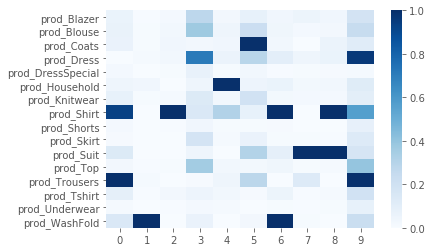

In [41]:
sns.heatmap(kmeans.cluster_centers_.T, yticklabels=prod_cols, cmap='Blues')

Text(0,0.5,'Days until second order')

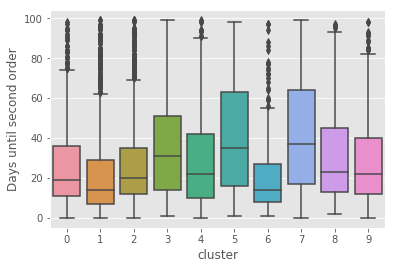

In [42]:
df_train['cluster'] = kmeans.labels_
sns.categorical.boxplot(df_train.cluster, df_train.loc[df_train.order_comp_num == 0].days_until_next_comp)
plt.ylabel('Days until second order')

In [43]:
cluster_meds = df_train.loc[df_train.order_comp_num == 0].groupby('cluster').days_until_next_comp.median()

In [44]:
cluster_meds

cluster
0    19.0
1    14.0
2    20.0
3    31.0
4    22.0
5    35.0
6    14.0
7    37.0
8    23.0
9    22.0
Name: days_until_next_comp, dtype: float64

In [45]:
cluster_centers = pd.DataFrame(index=range(0,10), columns=prod_cols, data=kmeans.cluster_centers_)
cluster_centers['next_order_prediction_days'] = df_train.loc[df_train.order_comp_num == 0].groupby('cluster').days_until_next_comp.median()
cluster_centers.to_csv('../data/cluster_centers.csv', index=True, index_label='cluster_number')

In [46]:
cluster_centers

,prod_Blazer,prod_Blouse,prod_Coats,prod_Dress,prod_DressSpecial,prod_Household,prod_Knitwear,prod_Shirt,prod_Shorts,prod_Skirt,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,next_order_prediction_days
0,0.064720,0.073832,6.775701e-02,1.258715e-14,0.021963,4.649533e-02,0.082009,9.371495e-01,0.023364,0.012383,1.334112e-01,0.029907,1.000000e+00,0.092290,0.017757,1.478972e-01,19.0
1,0.004935,0.009870,9.340853e-03,1.586183e-02,0.003525,3.701093e-02,0.008107,8.337775e-14,0.001410,0.002467,3.877335e-03,0.006521,1.744801e-02,0.007755,0.001057,1.000000e+00,14.0
2,0.022730,0.031801,3.732666e-02,3.472005e-02,0.008133,-3.705369e-15,0.018455,1.000000e+00,0.005213,0.002815,-4.768408e-14,0.009905,2.464695e-14,0.028151,0.006673,3.841372e-14,20.0
3,0.278545,0.373091,3.054545e-02,7.185455e-01,0.077818,4.509091e-02,0.133091,1.469091e-01,0.035636,0.179636,4.509091e-02,0.360727,1.527273e-02,0.053818,0.021818,6.981818e-02,31.0
4,0.028005,0.043716,3.756831e-02,6.147541e-02,0.008880,1.000000e+00,0.034836,3.155738e-01,0.008197,0.015710,4.274359e-15,0.034153,4.303279e-02,0.032787,0.016393,-3.885781e-15,22.0
5,0.079167,0.225694,1.000000e+00,2.923611e-01,0.031944,5.277778e-02,0.191667,7.986111e-02,0.008333,0.069444,3.111111e-01,0.023611,2.819444e-01,0.013889,0.003472,3.055556e-02,35.0
6,0.037783,0.040932,3.274559e-02,9.886650e-02,0.006297,6.360202e-02,0.027078,1.000000e+00,0.014484,0.008816,9.068010e-02,0.041562,6.467049e-15,0.057935,0.010076,1.000000e+00,14.0
7,0.056699,0.021033,-7.910339e-16,4.343850e-02,0.010517,2.652035e-02,0.021491,-9.436896e-15,0.002743,0.011431,1.000000e+00,0.008230,1.307727e-01,0.005030,0.004115,8.687700e-03,37.0
8,0.038547,0.028169,6.115641e-02,6.300964e-02,0.013714,3.409933e-02,0.020385,1.000000e+00,0.001483,0.004818,1.000000e+00,0.017791,2.692291e-15,0.017420,0.008895,1.043610e-14,23.0
9,0.185093,0.242857,1.149068e-01,9.621118e-01,0.018634,1.186335e-01,0.103727,5.683230e-01,0.083230,0.131677,1.683230e-01,0.396894,9.950311e-01,0.195031,0.080745,2.273292e-01,22.0


In [47]:
cluster_meds = df_train.loc[df_train.order_comp_num == 0].groupby(['city', 'cluster']).days_until_next_comp.median()

In [48]:
df_test['cluster'] = metrics.pairwise_distances(df_test[prod_cols], kmeans.cluster_centers_).argmin(axis=1)

In [49]:
df_test['cluster_med'] = cluster_meds.loc[df_test.city][df_test.cluster].values
df_train['cluster_med'] = cluster_meds[df_train.cluster].values
df_test['cluster_error'] = df_test.days_until_next_comp - df_test.cluster_med

In [50]:
metrics.mean_absolute_error(df_test.days_until_next_comp, df_test.cluster_med)

14.753525098702763

In [51]:
metrics.mean_absolute_error(df_test.loc[df_test.order_comp_num == 0].days_until_next_comp, df_test.loc[df_test.order_comp_num == 0].cluster_med)

18.055737704918034

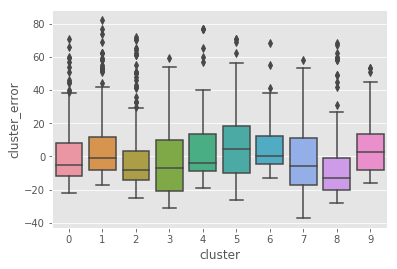

In [52]:
sns.categorical.boxplot(df_test.cluster, df_test.cluster_error)

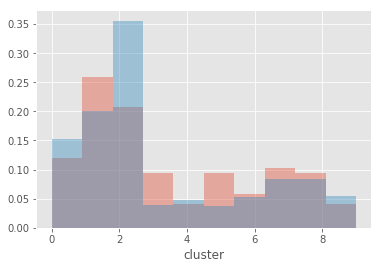

In [53]:
df_test.loc[df_test.order_comp_num == 0].shape, df_test.loc[df_test.order_comp_num > 0].shape
sns.distplot(df_test.loc[df_test.order_comp_num == 0].cluster, kde=False, bins=10, norm_hist=True)
sns.distplot(df_test.loc[df_test.order_comp_num > 0].cluster, kde=False, bins=10, norm_hist=True)

(0, 25)

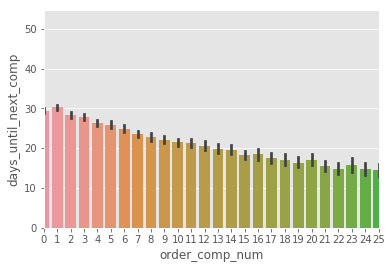

In [54]:
sns.barplot(df_known.order_comp_num, df_known.days_until_next_comp)
plt.xlim(0,25)